# Let's see the data

### Garbage in garbage out
Data is coming from scraping, and it is changing so rapidly, needs to be careful

**Collections in Database**
* video_detail : contains title, url, published date, video_id of video
* view_count : contains # of views, comments, likes
* comments : contatins comments for video

In [1]:
# Import prerequsities
import pandas as pd
import numpy as np
import time

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from pymongo import MongoClient
from datetime import datetime, timedelta

In [2]:
# connect mongodb through ssh tunnel
connection = MongoClient(port=47017)
db = connection['youtube_scrap']

### Video Detail

#### contains basic information of video
* title
* url
* published date

In [3]:
def get_all_collection(coll, filters=None):
    """Returns the list of objects in mongodb collection"""
    cursor = coll.find({})
    results = [obj for obj in cursor]
    return results
    

In [4]:
video_coll = db['video_detail']

In [5]:
videos = get_all_collection(video_coll)

In [6]:
len(videos)

270

In [7]:
videos[0]

{'_id': ObjectId('5d13aed7e70a248460e5833f'),
 'video_id': 'YBnGBb1wg98',
 'title': "Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV",
 'url': 'https://www.youtube.com/watch?v=YBnGBb1wg98',
 'published': 'Premiered Jun 19, 2019',
 'has_comment': 'Y'}

In [8]:
# Get thumbnail image from yotube
from simshow import simshow

# Show_Thumbnail
def show_thumbnail(video_id):
    url = f'http://img.youtube.com/vi/{video_id}/mqdefault.jpg'
    simshow(url)

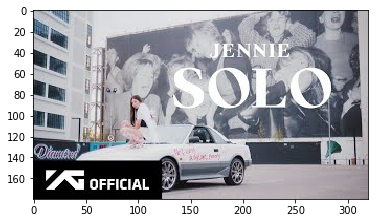

In [9]:
# Check with one video
video = videos[7]
show_thumbnail(video['video_id'])

#### put it into dataframe

In [10]:
video_df = pd.DataFrame(videos)
video_df.head()

,_id,has_comment,published,title,url,video_id
0,5d13aed7e70a248460e5833f,Y,"Premiered Jun 19, 2019",Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV,https://www.youtube.com/watch?v=YBnGBb1wg98,YBnGBb1wg98
1,5d13aedee70a248460e58340,Y,"Premiered Apr 4, 2019",BLACKPINK - 'Kill This Love' M/V,https://www.youtube.com/watch?v=2S24-y0Ij3Y,2S24-y0Ij3Y
2,5d13aee5e70a248460e58341,Y,"Published on Apr 12, 2019",BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,https://www.youtube.com/watch?v=XsX3ATc3FbA,XsX3ATc3FbA
3,5d13aeebe70a248460e58342,Y,"Published on Jun 19, 2019","Stray Kids ""부작용(Side Effects)"" M/V",https://www.youtube.com/watch?v=5rPluw_-Eb4,5rPluw_-Eb4
4,5d13aef1e70a248460e58343,Y,"Published on Jun 13, 2019",SOMI (전소미) - 'BIRTHDAY' M/V,https://www.youtube.com/watch?v=oDJ4ct59NC4,oDJ4ct59NC4


In [11]:
# Cleaning published date
video_df['published'] = [string.replace('Premiered', '') for string in video_df['published']]
video_df['published'] = [string.replace('Published', '') for string in video_df['published']]
video_df['published'] = [string.replace('on', '') for string in video_df['published']]

In [12]:
# convert it to datetime
video_df['published'] = pd.to_datetime(video_df['published'])

In [13]:
video_df['published'][0]

Timestamp('2019-06-19 00:00:00')

### Number of Published by Month

In [14]:
def show_by_month(by_date):
    """Draw a published by month chart"""

    # Set style for pyplot
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Number of Published Video by Month')
    ax.bar(by_date.index, by_date)
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Count')
    plt.show()

In [15]:
# Add YearMonth column for group by
video_df['pub_year_month'] = video_df['published'].apply(lambda x: 
                                                    '{year}-{month}'.format(year=x.year, 
                                                                            month=x.month))


In [16]:
published_by_month = video_df.groupby(['pub_year_month'])['title'].nunique()

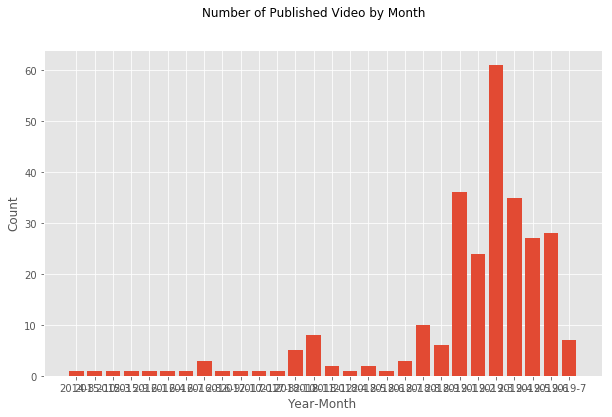

In [17]:
show_by_month(published_by_month)

#### Just focus on after 2019

In [18]:
after_2019 = video_df[video_df['published'] 
                   >= '2019-01-01'].groupby(['pub_year_month'])['title'].nunique()


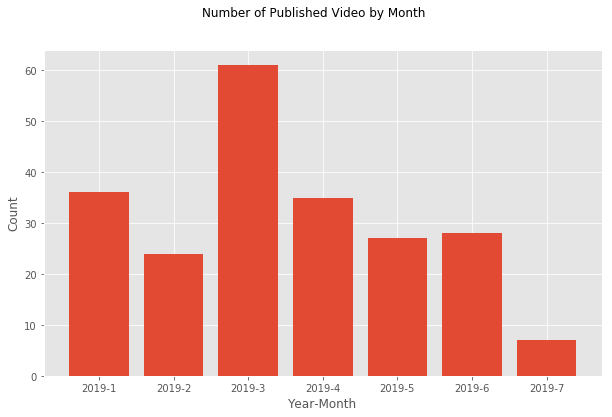

In [19]:
show_by_month(after_2019)

### View Count

#### contains performance of video at a moment
* video_id
* timestamp
* number of views, likes, and comments

In [20]:
view_count_coll = db['view_count']

In [21]:
view_counts = get_all_collection(view_count_coll)

In [22]:
# number of view_counts at now, it is increasing by scrapper
print(f'{datetime.now()} - {len(view_counts)}')
time.sleep(10)
view_counts = get_all_collection(view_count_coll)
print(f'{datetime.now()} - {len(view_counts)}')

2019-07-07 10:01:57.337521 - 121994
2019-07-07 10:02:16.888799 - 121996


In [23]:
view_count_df = pd.DataFrame(view_counts)

In [24]:
view_count_df.head()

,_id,comment_count,like_count,timestamp,title,video_id,view_count
0,5d13b6a99ec6103a9817d745,1530,25277,2019-06-26 18:17:09.330,모모랜드(MOMOLAND) - 바나나차차(뽀로로 삽입곡) M/V,kxdEoCDzm-k,502364
1,5d13b6b39ec6103a9817d746,583595,3508382,2019-06-26 18:17:19.652,EXO 엑소 'Love Shot' MV,pSudEWBAYRE,159871130
2,5d13b6bb9ec6103a9817d747,21557,244273,2019-06-26 18:17:27.695,A.C.E(에이스) - UNDER COVER M/V,qODWFe6v3zA,3169154
3,5d13b6c69ec6103a9817d748,2187,92749,2019-06-26 18:17:38.798,[MV] BOL4(볼빨간사춘기) _ Stars over me(별 보러 갈래?),8n9wklIG9qU,4289213
4,5d13b6cf9ec6103a9817d749,93467,1023889,2019-06-26 18:17:47.620,NCT 127 엔시티 127 'Simon Says' MV,arjy2v7zEI0,31832124


In [25]:
# Fix some missed data from scrapping

# cursor = view_count_coll.find({'video_id' : { '$exists': False}})

# for view in cursor:
#     video_id = video_df[video_df['title'] == view['title']]['video_id']

#     view_count_coll.update_one({"_id": view["_id"]},
#                                {"$set": {"video_id": video_id.values[0]}})


In [26]:
# View count for first video
view_count = view_count_df[view_count_df['video_id'] == video['video_id']]

In [27]:
view_count.sort_values(by='timestamp').head()


,_id,comment_count,like_count,timestamp,title,video_id,view_count
148,5d13bc379ec6103a9817d7d9,460909,5781099,2019-06-26 18:40:51.253,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331503901
181,5d13bdc49ec6103a9817d7fa,460911,5781109,2019-06-26 18:47:28.424,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331508719
425,5d13c6ba9ec6103a9817d8ee,460907,5781211,2019-06-26 19:25:42.282,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331527799
640,5d13cf6b9ec6103a9817d9c5,460912,5781345,2019-06-26 20:02:47.040,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331542175
708,5d13d2469ec6103a9817da09,460913,5781381,2019-06-26 20:14:58.291,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331549621


#### Let's check scrapper is working

In [28]:
# register converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

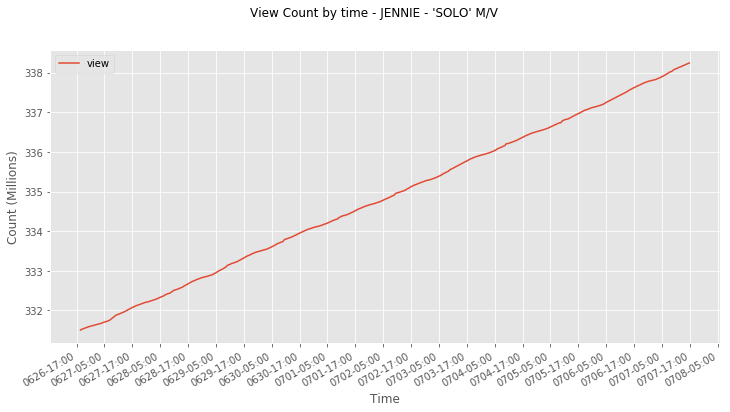

In [29]:
# See the changes by time
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle(f'View Count by time - {video["title"]}')

ax.plot(view_count['timestamp'], 
        view_count['view_count'] / 1_000_000, 
        '-', 
        label='view')
             
# ax.plot(view_count['timestamp'],
#         view_count['like_count'],
#         '-',
#         label='like')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m%d-%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

ax.set_xlabel('Time')
ax.set_ylabel('Count (Millions)')

fig.autofmt_xdate()

plt.legend()             
plt.show()

### Check with the most recent data

In [30]:
# single video has a lot of view counts by time
# need to get max value by title (need to change to video_id)
# get group by value with mongodb's aggregate function
view_max_count =[row for row in view_count_coll.aggregate([
    {'$group' : {'_id':'$video_id', 
                 'view_count':{'$max':'$view_count'}, 
                 'like_count':{'$max':'$like_count'},
                 'comment_count':{'$max':'$comment_count'},
                }
    }
])]

In [31]:
view_count_df = pd.DataFrame(view_max_count)
view_count_df.columns=['video_id', 'comment_count', 'like_count', 'view_count']

In [32]:
view_count_df.head()

,video_id,comment_count,like_count,view_count
0,-Cyg8rAA0F4,1,13,403
1,P_yjS9gwkGU,0,0,21
2,kb0-Bvk9FWc,665,4668,20588
3,zc67J3XybVY,960,28695,355615
4,LN8PMmThwDo,1,24,753


In [33]:
len(view_count_df)

270

In [34]:
# Merge with video_detail
df = pd.merge(video_df, view_count_df, on='video_id')
df.head()

,_id,has_comment,published,title,url,video_id,pub_year_month,comment_count,like_count,view_count
0,5d13aed7e70a248460e5833f,Y,2019-06-19,Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV,https://www.youtube.com/watch?v=YBnGBb1wg98,YBnGBb1wg98,2019-6,181522,1751191,36828184
1,5d13aedee70a248460e58340,Y,2019-04-04,BLACKPINK - 'Kill This Love' M/V,https://www.youtube.com/watch?v=2S24-y0Ij3Y,2S24-y0Ij3Y,2019-4,1445311,9293468,467323447
2,5d13aee5e70a248460e58341,Y,2019-04-12,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,https://www.youtube.com/watch?v=XsX3ATc3FbA,XsX3ATc3FbA,2019-4,3704807,11265402,438593725
3,5d13aeebe70a248460e58342,Y,2019-06-19,"Stray Kids ""부작용(Side Effects)"" M/V",https://www.youtube.com/watch?v=5rPluw_-Eb4,5rPluw_-Eb4,2019-6,85508,855768,27558615
4,5d13aef1e70a248460e58343,Y,2019-06-13,SOMI (전소미) - 'BIRTHDAY' M/V,https://www.youtube.com/watch?v=oDJ4ct59NC4,oDJ4ct59NC4,2019-6,91206,1693030,30355000


#### Check with histogram for the features

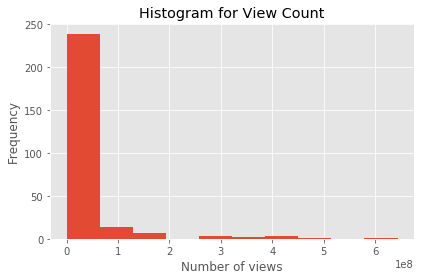

In [35]:
fig = df['view_count'].hist()
fig.set_xlabel('Number of views')
fig.set_ylabel('Frequency')
fig.set_title('Histogram for View Count')
plt.tight_layout()


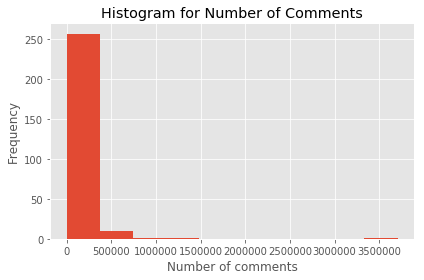

In [36]:
fig = df['comment_count'].hist();
fig.set_xlabel('Number of comments')
fig.set_ylabel('Frequency')
fig.set_title('Histogram for Number of Comments')
plt.tight_layout()

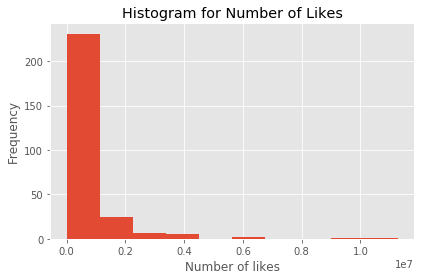

In [37]:
fig = df['like_count'].hist();
fig.set_xlabel('Number of likes')
fig.set_ylabel('Frequency')
fig.set_title('Histogram for Number of Likes')
plt.tight_layout()

### Comments

#### contains comments
* video_id
* comment text
* sentiment (probablity of positive)

In [38]:
comments_coll = db['comments']

In [39]:
comments = get_all_collection(comments_coll)

In [40]:
comments[0]

{'_id': ObjectId('5d13bbade70a248460e583ee'),
 'video_id': 'YBnGBb1wg98',
 'comment': "How many international fans are here ?\n\n\n\n\n\n\n\n\nI'm from the Philippines and currently live in America",
 'sentiment': 0.7865389082121107}

In [41]:
comments_df = pd.DataFrame(comments)

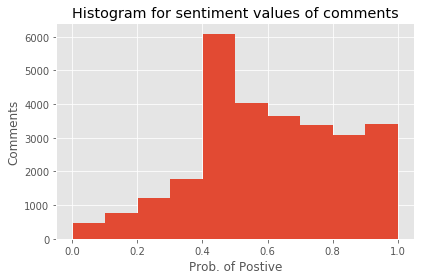

In [42]:
fig = comments_df['sentiment'].hist();
fig.set_xlabel('Prob. of Postive')
fig.set_ylabel('Comments')
fig.set_title('Histogram for sentiment values of comments')
plt.tight_layout()

#### Get average sentiment value for each video

In [43]:
# if setiment value is not setted yet, assume it to neutral
comments_df['sentiment'].fillna(0.5, inplace=True)

In [44]:
# get average sentiment value group by video_id
sentiment_df = comments_df.groupby('video_id').mean()

In [45]:
# merge with video first
temp_df = pd.merge(video_df, sentiment_df, on='video_id')
len(temp_df)

259

In [46]:
# then merge with view_count
df = df = pd.merge(temp_df, view_count_df, on='video_id')

In [47]:
df.head()

,_id,has_comment,published,title,url,video_id,pub_year_month,sentiment,comment_count,like_count,view_count
0,5d13aed7e70a248460e5833f,Y,2019-06-19,Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV,https://www.youtube.com/watch?v=YBnGBb1wg98,YBnGBb1wg98,2019-6,0.662094,181522,1751191,36828184
1,5d13aedee70a248460e58340,Y,2019-04-04,BLACKPINK - 'Kill This Love' M/V,https://www.youtube.com/watch?v=2S24-y0Ij3Y,2S24-y0Ij3Y,2019-4,0.575991,1445311,9293468,467323447
2,5d13aee5e70a248460e58341,Y,2019-04-12,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,https://www.youtube.com/watch?v=XsX3ATc3FbA,XsX3ATc3FbA,2019-4,0.619329,3704807,11265402,438593725
3,5d13aeebe70a248460e58342,Y,2019-06-19,"Stray Kids ""부작용(Side Effects)"" M/V",https://www.youtube.com/watch?v=5rPluw_-Eb4,5rPluw_-Eb4,2019-6,0.678712,85508,855768,27558615
4,5d13aef1e70a248460e58343,Y,2019-06-13,SOMI (전소미) - 'BIRTHDAY' M/V,https://www.youtube.com/watch?v=oDJ4ct59NC4,oDJ4ct59NC4,2019-6,0.583048,91206,1693030,30355000


### More detail

In [48]:
# Define function for chart
def draw_barchart(x, 
                  y,
                  xlabel='title',
                  ylabel='count',
                  title='Top 5', 
                  figsize=(8, 6)):
    """Draw bar chart for top5 video"""
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(title)

    ax.bar(x, y)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    labels = [title[:10] + '...' for title in x]
    plt.xticks(x, labels)

    plt.show()

#### Top 5 most watched video

In [49]:
# Extract top 5
top5= df.nlargest(5, 
                  columns=['view_count']).loc[:,
                                              ['title', 
                                               'view_count', 
                                               'published', 
                                               'video_id']]

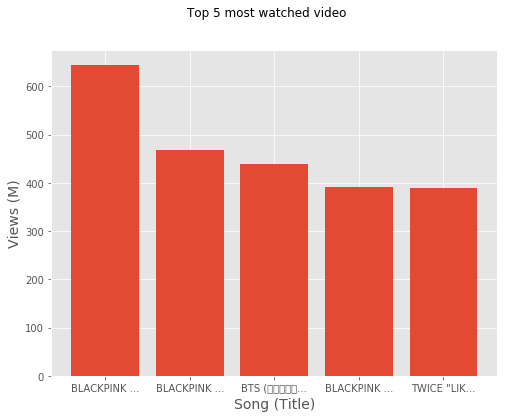

In [50]:
# Draw chart with top5 watched video
draw_barchart(x=top5['title'], 
              y=top5['view_count'] / 1_000_000,
              xlabel='Song (Title)',
              ylabel='Views (M)',
              title='Top 5 most watched video')

#### Top 5 most liked video

In [51]:
# Extract top 5 liked video
top5_like = df.nlargest(5, 
                        columns=['like_count']).loc[:, 
                                                    ['title', 
                                                     'like_count',
                                                     'published',                                     
                                                     'video_id']]


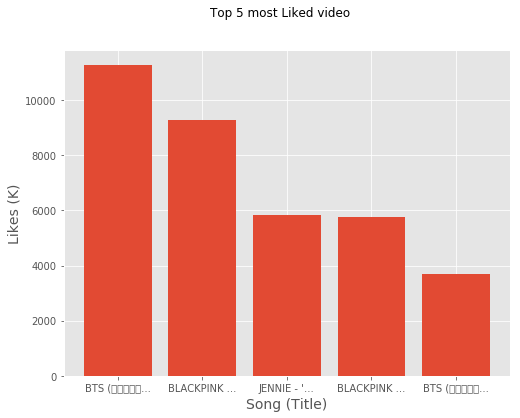

In [52]:
# Draw chart
draw_barchart(x=top5_like['title'], 
              y=top5_like['like_count'] / 1_000,
              xlabel='Song (Title)',
              ylabel='Likes (K)',
              title='Top 5 most Liked video')

#### Top 5 most commented video

In [53]:
# Extract top 5 liked video
top5_comment = df.nlargest(5, 
                        columns=['comment_count']).loc[:, 
                                                       ['title', 
                                                        'comment_count',
                                                        'published',                                     
                                                        'video_id']]


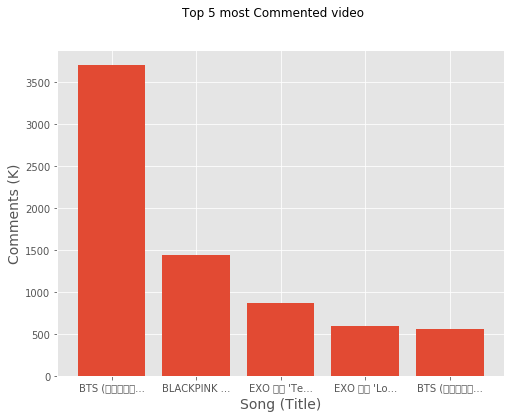

In [54]:
# Draw chart
draw_barchart(x=top5_comment['title'], 
              y=top5_comment['comment_count'] / 1_000,
              xlabel='Song (Title)',
              ylabel='Comments (K)',
              title='Top 5 most Commented video')

#### Select a video and see detail

In [55]:
# Select most watched video
top_video = top5.iloc[0]
top_video

title         BLACKPINK - '붐바야'(BOOMBAYAH) M/V
view_count                           644029729
published                  2016-08-08 00:00:00
video_id                           bwmSjveL3Lc
Name: 76, dtype: object

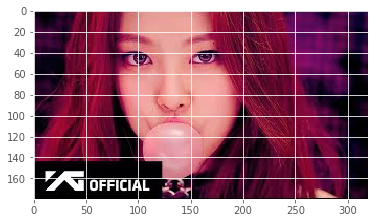

In [56]:
show_thumbnail(top_video['video_id'])

In [57]:
def get_view_counts(video_id):
    """Return all scrapped view count for video_id"""
    view_count_coll = db['view_count']
    cur = view_count_coll.find({'video_id': video_id}).sort('timestamp')
    
    view_counts = [record for record in cur]
    return pd.DataFrame(view_counts)

In [58]:
def draw_count_chart(data, fields=['view_count'], title='Count by Time', figsize=(12, 6)):
    """Draw a chart with data(timestamp, counts)"""
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(title)

    divider = 1
    div_label = ''

    for field in fields:
        divider = 1_000 if data[field].max() > 90_000 else divider
        div_label = ' (K)' if divider == 1_000 else div_label

        divider = 1_000_000 if data[field].max() > 90_000_000 else divider
        div_label = ' (M)' if divider == 1_000_000 else div_label

        ax.plot(data['timestamp'], 
                data[field] / divider, 
                '-',
                label=field)

    hours = mdates.HourLocator(interval = 12)
    h_fmt = mdates.DateFormatter('%m%d-%H:%M')

    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)

    ax.set_xlabel('Time')
    ax.set_ylabel('Count' + div_label)
    fig.autofmt_xdate()
    plt.legend()
    plt.show()
             

In [59]:
# Get all view counts that scrapped by time
view_counts = get_view_counts(top_video['video_id'])

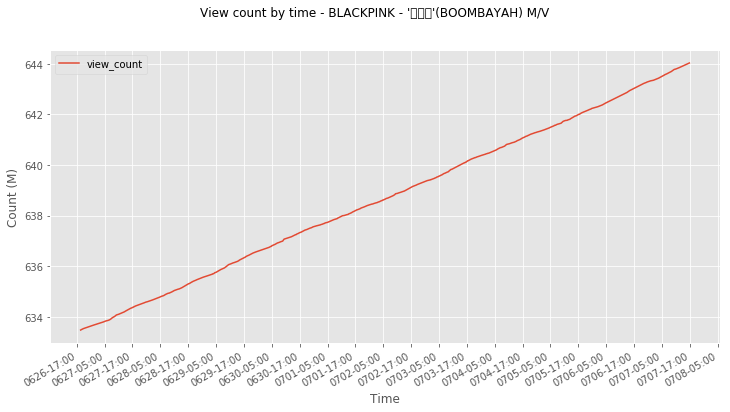

In [60]:
# Draw a chart
draw_count_chart(view_counts, 
                 title=f'View count by time - {top_video["title"]}')

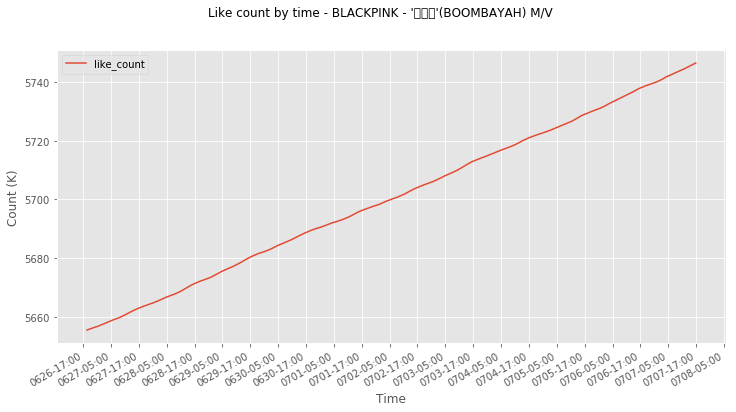

In [61]:
draw_count_chart(view_counts, 
                 title=f'Like count by time - {top_video["title"]}', 
                 fields=['like_count'])

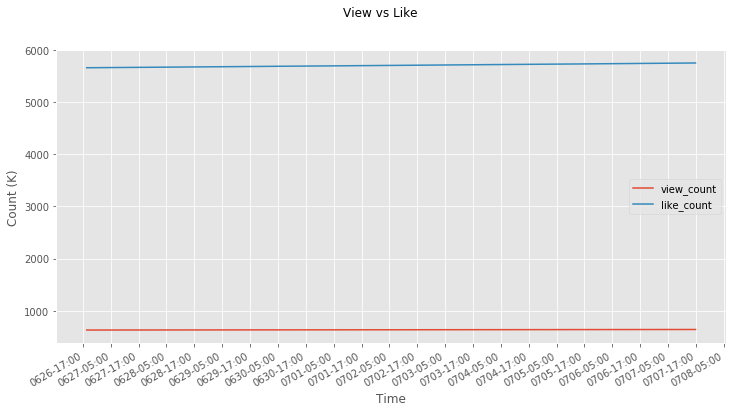

In [62]:
# Let's compare view with like
draw_count_chart(view_counts, 
                 title='View vs Like', 
                 fields=['view_count', 'like_count'])

#### It is hard to compare with like & view count because of its scale
#### Make another index to compare

In [63]:
# Add View Increasing Rate : added / prev_count
def add_inc_rate(df, field='view_count'):
    """Add """
    for i, row in view_counts.iterrows():
        if i > 0:
            added = df.loc[i, field] - df.loc[i - 1, field]
            df.loc[i, f'{field}_inc_rate'] = added / df.loc[i, field]
        else:
            df.loc[i, f'{field}_inc_rate'] = 0
        

In [64]:
# add view_count increasing rate
add_inc_rate(view_counts)

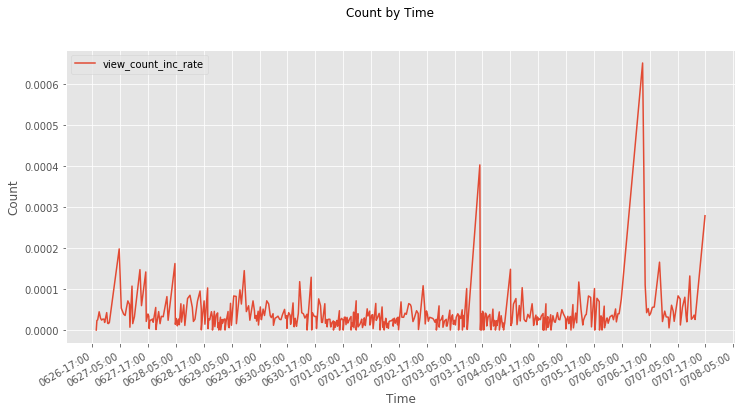

In [65]:
# draw a chart
draw_count_chart(view_counts, fields=['view_count_inc_rate'])

In [66]:
# increasing rate for like count
add_inc_rate(view_counts, field='like_count')

In [67]:
# increasing rate for comments count
add_inc_rate(view_counts, field='comment_count')

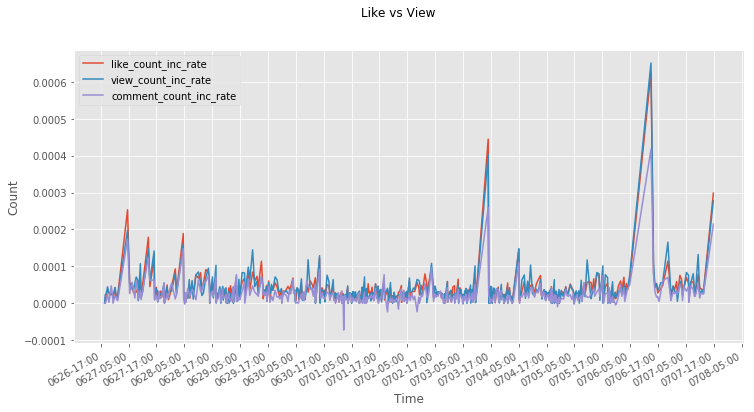

In [68]:
# Let's compare with like & view
draw_count_chart(view_counts, 
                 title='Like vs View', 
                 fields=['like_count_inc_rate', 
                         'view_count_inc_rate',
                         'comment_count_inc_rate'])

#### Much clear than before, it could be helpful for predicting the view count

### More analysis for Web App

#### Set increment to view_count document

In [69]:
now = datetime.now()
now

datetime.datetime(2019, 7, 7, 10, 2, 24, 800774)

In [70]:
# Set 4 hours ago
ago =  now - timedelta(hours=4)
ago

datetime.datetime(2019, 7, 7, 6, 2, 24, 800774)

In [77]:
# get min(view_count) group by video_id
min_cur = view_count_coll.aggregate([
    {'$match': {'timestamp': {"$gt": ago}}},
    {'$group' : {'_id':'$video_id', 
                 'view_count':{'$min':'$view_count'} 
                }
    }
])

In [78]:
# get max(view_count) group by video_id
max_cur = view_count_coll.aggregate([
    {'$match': {'timestamp': {"$gt": ago}}},
    {'$group' : {'_id':'$video_id', 
                 'view_count':{'$max':'$view_count'} 
                }
    }
])

In [79]:
min_view_count = np.array([row['view_count'] for row in min_cur])

In [80]:
max_view_count = np.array([row['view_count'] for row in max_cur])

In [81]:
# increment for last 4 hours
max_view_count.sum() - min_view_count.sum()

7819683

#### Find most hot videos

In [149]:
# get max(view_count) group by video_id
cur = view_count_coll.aggregate([
    {'$match': {'timestamp': {"$gt": ago}}},
    {'$group' : {'_id':'$video_id', 
                       'prev_count': {'$min':'$view_count'} ,
                       'view_count': {'$max':'$view_count'}}
    },
    {'$addFields': {'increment': {'$subtract': ['$view_count', '$prev_count']}}},
    { "$sort": { "increment": -1 } }
])

In [150]:
# save query result to list
video_views = [row for row in cur]

In [151]:
# show top 3
video_views[:3]

[{'_id': '2S24-y0Ij3Y',
  'prev_count': 466254116,
  'view_count': 467683830,
  'increment': 1429714},
 {'_id': 'XsX3ATc3FbA',
  'prev_count': 437709382,
  'view_count': 439033727,
  'increment': 1324345},
 {'_id': 'bwmSjveL3Lc',
  'prev_count': 643557997,
  'view_count': 644215173,
  'increment': 657176}]

In [152]:
# Get name of top 5 video
for row in video_views[:5]:
    video_id = row['_id']
    cur = video_coll.find({'video_id': video_id})
    video = cur.next()
    row.update(video)
    print(video['title'])
    

BLACKPINK - 'Kill This Love' M/V
BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. Halsey' Official MV
BLACKPINK - '붐바야'(BOOMBAYAH) M/V
TWICE "FANCY" M/V
JENNIE - 'SOLO' M/V


In [134]:
video_views[0]

{'_id': ObjectId('5d13aedee70a248460e58340'),
 'prev_count': 466254116,
 'view_count': 467342388,
 'increment': 1088272,
 'video_id': '2S24-y0Ij3Y',
 'title': "BLACKPINK - 'Kill This Love' M/V",
 'url': 'https://www.youtube.com/watch?v=2S24-y0Ij3Y',
 'published': 'Premiered Apr 4, 2019',
 'has_comment': 'Y'}

#### Find most watched video

In [136]:
# get max view_count among the view_count by video_id
# max value of view_count could be current view_count
current_cur = view_count_coll.aggregate([
    {'$group' : {'_id':'$video_id', 
                 'view_count':{'$max':'$view_count'} 
                }
    },
    { "$sort": { "view_count": -1 } }
])

In [137]:
# save query result to list
view_counts = [row for row in current_cur]

In [139]:
# check top 5 view counts video
view_counts[:5]

[{'_id': 'bwmSjveL3Lc', 'view_count': 644167034},
 {'_id': '2S24-y0Ij3Y', 'view_count': 467590837},
 {'_id': 'XsX3ATc3FbA', 'view_count': 438934390},
 {'_id': 'dISNgvVpWlo', 'view_count': 392029576},
 {'_id': 'V2hlQkVJZhE', 'view_count': 390400276}]